<a href="https://colab.research.google.com/github/RajshreeM29/Twitter-Sentiment-Analysis/blob/master/Twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Analysis



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Step 1 - Import Packages 

In [0]:
#Importing relevant packages
import nltk
import os
nltk.download('punkt')
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from collections import Counter

import pandas as pd
import nltk
import numpy as np
import random
import string

import bs4 as bs
import urllib.request
import re

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import os
path = '.....(include loaction of files)'
os.chdir(path)


Step 2 - Import Data

In [0]:
#reading the document line by line
train_list = []         

mytxt = open("train_90.txt", 'rt', encoding = 'utf8')  #
 #we save each line of the document in the list called doc
 
for line in mytxt:   
    train_list.append(line)

mytxt.close()

myid = []
sentiment = []
src = []
mytext = []
sample = []
tweet = []
sep = ""
for i in range(1,len(train_list)):
  row = train_list[i].split(",")
  myid.append(row[0])
  sentiment.append(row[1])
  #src.append(row[2])
  mytext.append(sep.join(row[3:]))


training = [myid, sentiment, mytext]
training = pd.DataFrame(training)
training = training.transpose()
training.columns = ['ItemID',	'Sentiment',	'SentimentText']
training.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O\n
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [0]:
#reading the test line by line
test_list = []
mytxt = open("test_10.txt", 'rt', encoding = 'utf8')  #
 
 
for line in mytxt:   
    test_list.append(line)

mytxt.close()
myid = []
sentiment = []
mytext = []
sample = []
tweet = []
sep = ""
for i in range(1,len(test_list)):
  row = test_list[i].split(",")
  myid.append(row[0])
  sentiment.append(row[1])
  mytext.append(sep.join(row[3:]))


test = [myid, sentiment, mytext]
test = pd.DataFrame(test)
test = test.transpose()
test.columns = ['ItemID',	'Sentiment',	'SentimentText']
test.head()

,ItemID,Sentiment,SentimentText
0,90001,1,"""@CleverMonkeys but AFTER you hit up the Magno..."
1,90002,1,@CleverMonkeys only seen a boot on a car in mo...
2,90003,1,@clevertitania Good morning. We have rain and ...
3,90004,1,@clewis4u91 so glad i'm not there then \n
4,90005,0,@ClexIsEpic I MSS YOU! sad cookie\n


In [0]:
training["Sentiment"]= training.Sentiment.astype('category')
test["Sentiment"]= test.Sentiment.astype('category')

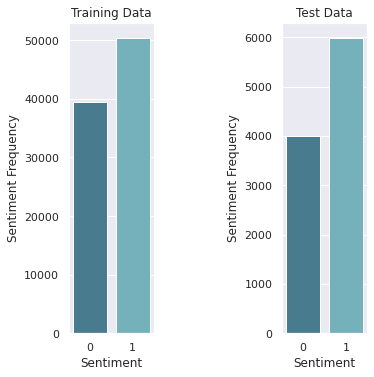

In [0]:
##Let us quickly look at the distribution of the target variable

fig, ax =plt.subplots(1,2 , figsize=(5,5))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)

sns.countplot(training['Sentiment'], ax=ax[0],palette='GnBu_d').set_title("Training Data",)
ax[0].set_ylabel("Sentiment Frequency")


sns.countplot(test['Sentiment'], ax=ax[1],palette='GnBu_d').set_title("Test Data")
ax[1].set_ylabel("Sentiment Frequency")
fig.show()

The data is balanced, target variable has even represenation in the training and test data

In [0]:
#combining the dataframes - since we will be extracting the tfidf features 
combi = training.append(test, ignore_index=True)


In [0]:
#Data cleaning and prepocessing - setting up a cleaning fucntion

def dataclean(mydataframe,index):
  mydataframe.iloc[:,index] = np.vectorize(remove_pattern)(mydataframe.iloc[:,index], "@[\w]*")#removing handles
  mydataframe.iloc[:,index] = mydataframe.iloc[:,index].str.replace("[^a-zA-Z#]", " ")#removing special charectars
  mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))#removing short words
  mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join(x.lower() for x in x.split()))#lower case

  #removing stop words
  stop = stopwords.words('english')
  mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  #apply stemming
  st = PorterStemmer()
  mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
  mydataframe.head()

  return mydataframe

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt


In [0]:
#cleaning up the training and test data

# %time training = dataclean(training,2)
# %time test = dataclean(test,2)
%time combi = dataclean(combi,2)

CPU times: user 16.9 s, sys: 170 ms, total: 17.1 s
Wall time: 17.1 s


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['SentimentText'])
print(tfidf.shape,type(tfidf))
    

(100000, 42127) <class 'scipy.sparse.csr.csr_matrix'>


In [0]:
len(tfidf_vectorizer.get_feature_names()) # number of features from the total dataset

42127

In [0]:
train_tfidf =tfidf[:90000,:]
test_tfidf = tfidf[90000:,:]

y = combi['Sentiment']
y_train = y[:90000]
y_test = y[90000:]



In [0]:
print("Training", train_tfidf.shape, y_train.shape)
print("Test", test_tfidf.shape, y_test.shape)

Training (90000, 42127) (90000,)
Test (10000, 42127) (10000,)


In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [0]:
%%time
##crossvalidation to tune the best value for the penalty
C = [.001,.01,.1,1.0,10]
best_c = -100000
best_acc = -100000
k = 3
for c in C:
  kf = KFold(k, shuffle=True, random_state=7) # Use for KFold classification
  fold_score = []

  score = []
  fold = 0

  for train, valid in kf.split(train_tfidf):
    fold+=1
    x_train_cv = train_tfidf[train]
    y_train_cv = y_train[train]
    x_val = train_tfidf[valid]
    y_val = y_train[valid]
    # print( "Fold#", fold)

    model = LogisticRegression(penalty = 'l2',C = c,solver = 'saga', tol =.00000001, random_state = 2911, max_iter=100000)
    model.fit(x_train_cv,y_train_cv)

    pred = model.predict(x_val)
      

    # Measure this fold's RMSE
    m = metrics.accuracy_score(pred,y_val)
    # print(round(m,3))
    score.append(m)
  fold_score = np.array(score).mean()
  if best_acc < fold_score:
    best_acc=fold_score
    best_c = c

 
  print("Average Accuracy for C =",c,"=",round(fold_score,3))
print('Best C = ', best_c, "For accuracy :", round(best_acc,3))

Average Accuracy for C = 0.001 = 0.561
Average Accuracy for C = 0.01 = 0.657
Average Accuracy for C = 0.1 = 0.727
Average Accuracy for C = 1.0 = 0.74
Average Accuracy for C = 10 = 0.727
Best C =  1.0 For accuracy : 0.74
CPU times: user 1min 21s, sys: 4.23 ms, total: 1min 21s
Wall time: 1min 21s


In [0]:
%%time
#Final Model

model = LogisticRegression(penalty = 'l2',C = best_c,solver = 'saga', tol =.00000001, random_state = 2911, max_iter=100000)
model.fit(train_tfidf,y_train)
pred = model.predict(test_tfidf)
print(classification_report(y_test,pred.transpose()))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66      4006
           1       0.77      0.83      0.80      5994

    accuracy                           0.75     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.75      0.74     10000

CPU times: user 7.37 s, sys: 5.81 ms, total: 7.38 s
Wall time: 7.38 s
